In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopy.distance as dist
import seaborn as sns
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

import helper as hlp

%matplotlib inline
plt.style.use('seaborn-poster')

In [3]:
boston_listings = pd.read_csv('data/boston/listings.csv', parse_dates=True)
seattle_listings = pd.read_csv('data/seattle/listings.csv', parse_dates=True)

In [4]:
boston_listings['review_scores_rating'].value_counts()

100.0    628
93.0     205
96.0     197
95.0     171
97.0     168
90.0     163
80.0     160
98.0     153
94.0     109
92.0     105
91.0      88
87.0      87
88.0      69
99.0      65
89.0      56
86.0      47
85.0      39
84.0      34
60.0      33
83.0      30
70.0      19
82.0      16
75.0      16
73.0      14
78.0      12
40.0      11
79.0      10
77.0       9
76.0       7
81.0       7
20.0       6
64.0       5
74.0       5
67.0       4
71.0       4
50.0       3
65.0       3
68.0       2
47.0       2
66.0       2
48.0       1
72.0       1
53.0       1
58.0       1
69.0       1
55.0       1
62.0       1
46.0       1
Name: review_scores_rating, dtype: int64

In [5]:
boston_listings['review_scores_value'].value_counts()

10.0    1177
9.0     1130
8.0      334
7.0       51
6.0       49
4.0       12
2.0        7
5.0        2
3.0        2
Name: review_scores_value, dtype: int64

In [6]:
boston_listings['review_scores_value'].fillna('Unrated', inplace=True)
boston_listings['review_scores_rating'].fillna('Unrated', inplace=True)
boston_listings['host_response_time'] = boston_listings['host_response_time'].astype('|S80')
boston_listings['host_response_time'] = boston_listings['host_response_time'].fillna(boston_listings['host_response_time'].mode())

boston_listings['bathrooms'].fillna(boston_listings['bathrooms'].mean(), inplace=True)
boston_listings['bedrooms'].fillna(boston_listings['bedrooms'].mean(), inplace=True)
boston_listings['beds'].fillna(boston_listings['beds'].mean(), inplace=True)
boston_listings['property_type'].fillna(method='ffill', inplace=True)

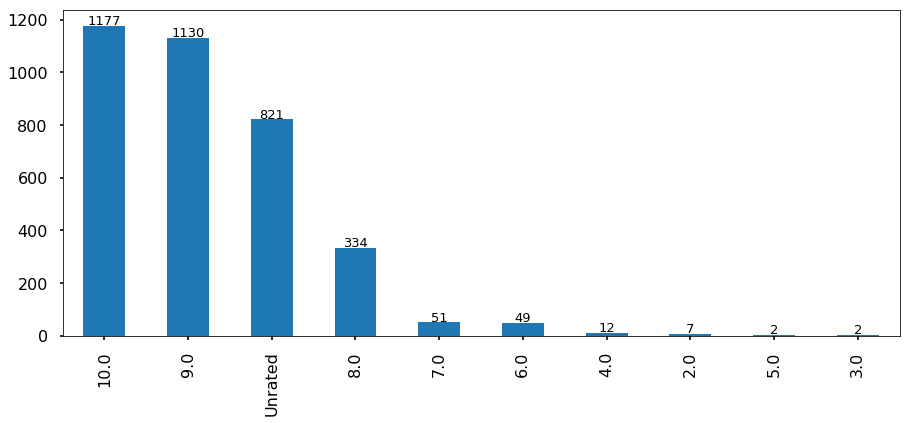

In [7]:
plt.figure(figsize =(15,6))
#fig, ax = plt.subplots(1,1)
#ax.grid(True, zorder=0)
ax = boston_listings.review_scores_value.value_counts().plot(kind='bar')
#ax.grid('on')
for p in ax.patches:
    height = p.get_height()
    ax.text((p.get_x() + p.get_width()/2.),
            height + 5,
            '%d' % int(height),
            ha='center',
            color='black',
            fontsize=13)
plt.ylim(bottom = -2);



In [8]:
def process_binary_categories(df, cols_to_encode):
    for col in cols_to_encode:
        df[col] = np.where(df[col] == 't', 1, 0)
    return df

def process_multi_categories(df, cols_to_encode):
    df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)
    return df

def process_amenities(df):
    ## We only want to get a subset of amenities - TV, Wifi, Kitchen, Internet, Free parking, Free street parking,
    # No Smoking/ Non Smoking, 24 hour check in, heating, air conditioning
    
    ## TODO: Check if we can do this dynamically
    ## TODO: Add house rules also
    
    df['amenities'] = df['amenities'].str.lower()
    df['TV'] = df['amenities'].str.contains('TV').astype(int)
    df['Wifi'] = df['amenities'].str.contains('wifi'or'internet').astype(int)
    df['Kitchen'] = df['amenities'].str.contains('kitchen').astype(int)
    df['Free parking'] = df['amenities'].str.contains('free parking').astype(int)
    df['Free Street parking'] = df['amenities'].str.contains('free street parking').astype(int)
    df['No Smoking'] = df['amenities'].str.contains('no smoking'or'non smoking').astype(int)
    df['24 hour check in'] = df['amenities'].str.contains('24 hour check in').astype(int)
    df['Heating'] = df['amenities'].str.contains('Heating').astype(int)
    df['Air conditioning'] = df['amenities'].str.contains('air conditioning').astype(int)
    return df

def process_prices(df, cols_to_process):
    for col in cols_to_process:
        df.loc[:, col] = df[col].replace( '[\$,)]','', regex=True ).astype('float64')
        df.loc[:, col] = df[col].fillna(0)
    return df

def process_special(df):
    df = df.apply(lambda col: pd.to_datetime(col, errors='ignore')
              if col.dtypes == object 
              else col, 
              axis=0)
    
    max_days = df['host_since'].max()
    df['host_since_days'] = max_days - df['host_since']
    df['host_since_days'] = df['host_since_days'].dt.days
    
    df['distance_center'] = df.apply(lambda x: dist.distance((x['latitude'], x['longitude']), 
                                    (42.3584300, -71.0597700)).km, axis = 1)
    
    df['host_response_rate'] = df['host_response_rate'].str.replace('%','').astype('float64')
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%','').astype('float64')
    
    df['host_response_rate'] = df['host_response_rate'].fillna(df['host_response_rate'].mean())
    df['host_acceptance_rate'] = df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].mean())
    
    return df

In [9]:
binary_cats = ['host_is_superhost', 'host_identity_verified', 'instant_bookable']
boston_listings = process_binary_categories(boston_listings, binary_cats)

In [10]:
multi_cats = ['property_type', 'room_type', 'bed_type', 'bathrooms', 'bedrooms', 'beds', 'cancellation_policy', 'neighbourhood_cleansed', 'host_response_time']
boston_listings = process_multi_categories(boston_listings, multi_cats)

In [11]:
price_cols = ['price', 'cleaning_fee', 'security_deposit', 'extra_people']
boston_listings = process_prices(boston_listings, price_cols)

In [12]:
boston_listings = process_amenities(boston_listings)
boston_listings = process_special(boston_listings)

In [13]:
## Drop columns we do not want
##From assessment #1
cols_to_be_dropped = ['neighbourhood_group_cleansed', 'has_availability', 'license', 'jurisdiction_names',
                     'scrape_id', 'last_scraped', 
                     'listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
                     'requires_license', 'country_code' , 'country']

##After pre processing and feature engineering, in addition to categorical columns 
# Being dropped either due to missing data or the assumption that they may not contribute to the prediction
cols_to_be_dropped.extend((
'amenities', 
'id', 'experiences_offered', 
'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_rating',
'review_scores_communication', 'review_scores_location', 'first_review', 'last_review', 'reviews_per_month',
'name','summary', 'space', 'description', 'neighborhood_overview','transit','notes', 'access', 'interaction', 
'house_rules', 'weekly_price', 'monthly_price', 'square_feet',
'host_id', 'host_url', 'host_location', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'host_since', 'street',
'neighbourhood', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country',
'availability_30','availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count',
'calendar_updated', 'calendar_last_scraped', 
'guests_included', 'minimum_nights', 'maximum_nights',
'is_location_exact'))

In [14]:
boston_listings.drop(cols_to_be_dropped, axis=1, inplace=True)

In [15]:
def categorize_rating(rating):
    """
    Map various categories to two distinct - 10 or less than 10
    """
    if rating > 9.0:
        return '10'
    else:
        return '9-'
    assert 0  # unexpected rating

In [17]:
boston_listings.drop(boston_listings.loc[boston_listings['review_scores_value']=='Unrated'].index, inplace=True)
y = boston_listings['review_scores_value'].map(categorize_rating)
X = boston_listings.drop('review_scores_value', axis = 1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
clf = LogisticRegression(multi_class='ovr', C=0.010)
logregclf = Pipeline([
        ('scaler', skl.preprocessing.StandardScaler()), ('logistic', clf)])

In [24]:
logregclf.fit(X_train, y_train)
skl.metrics.f1_score(y_test, logregclf.predict(X_test), average=None)

array([ 0.52354049,  0.7027027 ])

In [25]:
skl.metrics.accuracy_score(y_test, logregclf.predict(X_test))

0.63386396526772792

In [26]:
skl.metrics.log_loss(y_test, logregclf.predict_proba(X_test))

0.62738874359300434

In [27]:
logregclf.classes_

array(['10', '9-'], dtype=object)

In [28]:
skl.metrics.confusion_matrix(y_test, clf.predict(X_test), labels=logregclf.classes_).T

array([[ 10,   1],
       [290, 390]])

In [29]:
pd.crosstab(y_test, logregclf.predict(X_test), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,10,9-,All
True,,,
10,139,161,300
9-,92,299,391
All,231,460,691


In [30]:
def make_weight(y):
    """
    Return sample weights according to inverse class frequency
    y: Series of labels
    """
    weight_dict = dict(1/y.value_counts())
    return y.map(weight_dict)


def class_weighted_accuracy_score(estimator, X, y):
    """
    Scorer that uses accuracy after reweighting samples by class frequency
    """
    return skl.metrics.accuracy_score(y, estimator.predict(X),
                                      sample_weight=make_weight(y))

In [33]:

scaler = StandardScaler()
rfclf = RandomForestClassifier(n_estimators=100, criterion='gini', 
                                              max_features=103, max_depth=None, # Can experiment with this to regularize
                                              n_jobs=4, class_weight='balanced_subsample') # try 'subsample' too?
rf_pipe = Pipeline([
        ('scaler', scaler), ('clf', rfclf)])
param_grid={'clf__n_estimators': [100, 103]}
gridclf = GridSearchCV(rf_pipe, param_grid=param_grid, scoring=class_weighted_accuracy_score, 
                                            n_jobs=1, cv=3, verbose=1)
gridclf.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features=103,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_i...mators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__n_estimators': [100, 103]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<function class_weighted_accuracy_score at 0x1a17f6bea0>,
       verbose=1)

In [35]:
gridclf.grid_scores_

[mean: 0.67936, std: 0.00673, params: {'clf__n_estimators': 100},
 mean: 0.67445, std: 0.00464, params: {'clf__n_estimators': 103}]

In [41]:
scaler = skl.preprocessing.StandardScaler()
clf = skl.ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', 
                                              max_features='auto', max_depth=None,
                                              n_jobs=4, class_weight='balanced_subsample')
rf_pipe = skl.pipeline.Pipeline([
        ('scaler', scaler), ('clf', clf)])
param_grid={'clf__max_features': [10, 30, 40, 50, 60, 70, 90, 103]}
gridclf = skl.grid_search.GridSearchCV(rf_pipe, param_grid=param_grid, scoring=class_weighted_accuracy_score, 
                                            n_jobs=1, cv=3, verbose=1)
gridclf.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   11.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            mi...mators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__max_features': [10, 30, 40, 50, 60, 70, 90, 103]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<function class_weighted_accuracy_score at 0x1a17f6bea0>,
       verbose=1)

In [42]:
gridclf.grid_scores_

[mean: 0.66277, std: 0.02421, params: {'clf__max_features': 10},
 mean: 0.67909, std: 0.01628, params: {'clf__max_features': 30},
 mean: 0.67829, std: 0.00329, params: {'clf__max_features': 40},
 mean: 0.68642, std: 0.01785, params: {'clf__max_features': 50},
 mean: 0.68323, std: 0.01089, params: {'clf__max_features': 60},
 mean: 0.67646, std: 0.01229, params: {'clf__max_features': 70},
 mean: 0.68373, std: 0.00785, params: {'clf__max_features': 90},
 mean: 0.68114, std: 0.00997, params: {'clf__max_features': 103}]

In [43]:
gridclf.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features=50,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_im...mators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [44]:
scaler = skl.preprocessing.StandardScaler()
final_clf = skl.ensemble.RandomForestClassifier(n_estimators=100,
                                                  criterion='gini',
                                                  max_features=50,
                                                  max_depth=None,
                                                  n_jobs=4,
                                                  class_weight='balanced_subsample')
final_rf_pipe = skl.pipeline.Pipeline([('scaler', scaler), ('clf', final_clf)])

In [45]:
final_rf_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features=50,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_im...mators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [46]:
class_weighted_accuracy_score(final_rf_pipe, X_test, y_test)

0.63794117647058823

In [47]:
skl.metrics.confusion_matrix(y_test, final_rf_pipe.predict(X_test), labels=final_rf_pipe.classes_).T

array([[171, 115],
       [129, 276]])

In [48]:
pd.crosstab(y_test, final_rf_pipe.predict(X_test), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,10,9-,All
True,,,
10,171,129,300
9-,115,276,391
All,286,405,691


In [49]:
feature_importances = pd.DataFrame(final_rf_pipe.named_steps['clf'].feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                 
                                                                        ascending=False)
feature_importances

,importance
number_of_reviews,0.121987
host_since_days,0.079521
distance_center,0.077572
longitude,0.076288
price,0.069710
host_is_superhost,0.069113
latitude,0.066737
host_listings_count,0.042302
host_total_listings_count,0.040808
cleaning_fee,0.035207


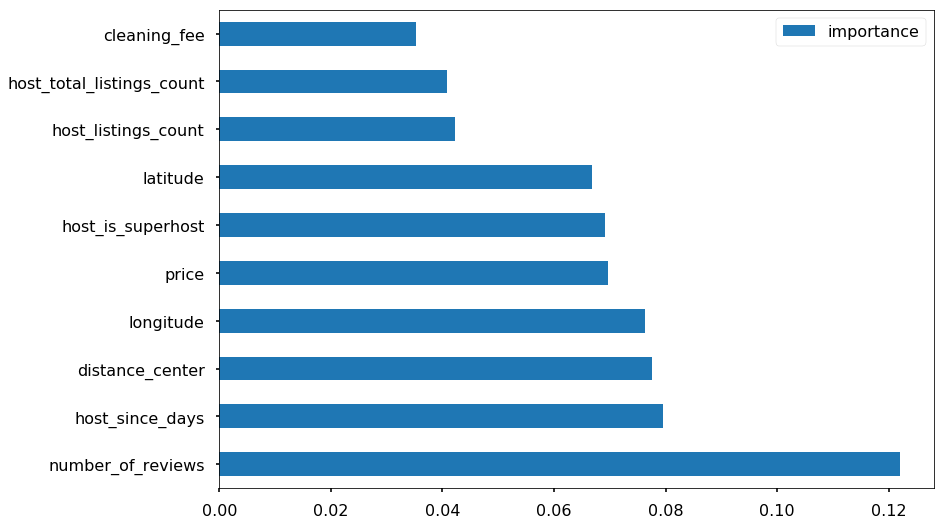

In [50]:
feature_importances.nlargest(10, 'importance').plot(kind='barh');